<a href="https://colab.research.google.com/github/Aishani17/intel-/blob/main/teacherintel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Mount Google Drive and unzip CelebA dataset
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path ="/content/drive/MyDrive/archive (14).zip"
extract_path = "/content/celeba_dataset"  # Destination folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction completed!")

Mounted at /content/drive
✅ Extraction completed!


In [ ]:
# Step 2: Generate Blurry Images (Improved Simulation)
import cv2
import numpy as np
import random
from tqdm import tqdm
import os

# Define input/output folders
sharp_folder = os.path.join(extract_path, "img_align_celeba", "img_align_celeba")
blurry_folder = os.path.join(extract_path, "blurry")

# Create output folder if not exists
os.makedirs(blurry_folder, exist_ok=True)

def apply_motion_blur(image, kernel_size=9):
    """Applies horizontal motion blur"""
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    kernel /= kernel_size
    return cv2.filter2D(image, -1, kernel)

def apply_random_blur(image):
    """Randomly applies Gaussian or Motion blur"""
    blur_type = random.choice(['gaussian', 'motion'])
    if blur_type == 'gaussian':
        return cv2.GaussianBlur(image, (9, 9), sigmaX=random.uniform(0.5, 1.5))
    else:
        return apply_motion_blur(image)

def create_blurry_images(src_folder, dest_folder, limit=8000, img_size=(128, 128)):
    count = 0
    file_list = [f for f in os.listdir(src_folder) if f.endswith(".jpg")]
    random.shuffle(file_list)

    for filename in tqdm(file_list, desc="Creating blurry images"):
        img_path = os.path.join(src_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        blurred = apply_random_blur(img)
        cv2.imwrite(os.path.join(dest_folder, filename), blurred)

        count += 1
        if count >= limit:
            break

# Run the function
create_blurry_images(sharp_folder, blurry_folder)
print("✅ Blurry images created.")

# Get matching pairs
common_files = list(set(os.listdir(blurry_folder)).intersection(set(os.listdir(sharp_folder))))
print(f"🖼️ Total matching image pairs: {len(common_files)}")

Creating blurry images:   4%|▍         | 7999/202599 [00:06<02:47, 1159.81it/s]


✅ Blurry images created.
🖼️ Total matching image pairs: 8000


In [ ]:
# Step 3: Dataset Splitting & Custom Data Generator

# 3.1: Dataset Splitting
from sklearn.model_selection import train_test_split

# Ensure consistent ordering
common_files = sorted(common_files)

# Split into train and validation sets
train_files, val_files = train_test_split(common_files, test_size=0.2, random_state=42)

print(f"📊 Training images: {len(train_files)}")
print(f"📊 Validation images: {len(val_files)}")

# 3.2: Custom Data Generator Class
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

class ImagePairGenerator(Sequence):
    def __init__(self, blurry_dir, sharp_dir, filenames, batch_size=16, img_size=(128, 128), shuffle=True):
        self.blurry_dir = blurry_dir
        self.sharp_dir = sharp_dir
        self.filenames = filenames
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.filenames) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

    def __getitem__(self, index):
        batch_files = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]
        x_batch, y_batch = [], []

        for file in batch_files:
            try:
                blur_path = os.path.join(self.blurry_dir, file)
                sharp_path = os.path.join(self.sharp_dir, file)

                blur_img = img_to_array(load_img(blur_path, target_size=self.img_size)) / 255.0
                sharp_img = img_to_array(load_img(sharp_path, target_size=self.img_size)) / 255.0

                x_batch.append(blur_img)
                y_batch.append(sharp_img)
            except Exception as e:
                print(f"Error loading {file}: {e}")
                continue

        return np.array(x_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

📊 Training images: 6400
📊 Validation images: 1600


In [ ]:
# Create training and validation generators
train_gen = ImagePairGenerator(blurry_folder, sharp_folder, train_files, batch_size=16)
val_gen = ImagePairGenerator(blurry_folder, sharp_folder, val_files, batch_size=16)

print("✅ Data generators ready.")

✅ Data generators ready.


In [ ]:
# Step 4: Build Enhanced UNet++ Style Model

# 4.1: Define Conv Block (with BatchNorm + LeakyReLU)
from tensorflow.keras import layers, Model

def conv_block(x, filters, kernel_size=3, dropout_rate=0.0):
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# 4.2: Define UNet++-Inspired Model
def build_advanced_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv_block(p2, 128, dropout_rate=0.3)

    # Decoder
    u2 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c3)
    u2 = layers.concatenate([u2, c2])
    c4 = conv_block(u2, 64)

    u1 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u1 = layers.concatenate([u1, c1])
    c5 = conv_block(u1, 32)

    outputs = layers.Conv2D(3, kernel_size=1, activation='sigmoid')(c5)

    model = Model(inputs, outputs, name="Enhanced_UNet")
    return model

In [ ]:
# 4.3 Instantiate Model
# Build the model
unet_model = build_advanced_unet((128, 128, 3))
unet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Enhanced_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]  

 Total params: 469,155 (1.79 MB)

 Trainable params: 467,875 (1.78 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
# Step 5: Define Loss Function and Compile Model

# 5.1: Define SSIM Metric and Combined Loss
import tensorflow as tf

# SSIM as a metric (returns value between -1 and 1, usually around 0–1)
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# Combined Loss: 50% MSE + 50% (1 - SSIM)
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_val = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.5 * mse + 0.5 * (1 - ssim_val)

In [ ]:
# 5.2: Compile the Model
from tensorflow.keras.metrics import MeanMetricWrapper

unet_model.compile(
    optimizer='adam',
    loss=combined_loss,
    metrics=[
        'mae',
        MeanMetricWrapper(ssim_metric, name='ssim')
    ]
)

print("✅ Model compiled successfully.")

✅ Model compiled successfully.


In [ ]:
# Step 6: Train the Model (with Callbacks & Generators)

# 6.1: Set Up Callbacks
from tensorflow.keras import callbacks

# Early stopping to halt if validation loss stops improving
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate if val_loss plateaus
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Optional: Save best model
checkpoint = callbacks.ModelCheckpoint(
    "/content/enhanced_unet_teacher.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
# 6.2: Train the Model
history = unet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1375 - mae: 0.0701 - ssim: 0.7373
Epoch 1: val_loss improved from inf to 0.14578, saving model to /content/enhanced_unet_teacher.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 48s 68ms/step - loss: 0.1374 - mae: 0.0700 - ssim: 0.7374 - val_loss: 0.1458 - val_mae: 0.0780 - val_ssim: 0.7173 - learning_rate: 0.0010
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0865 - mae: 0.0434 - ssim: 0.8307
Epoch 2: val_loss improved from 0.14578 to 0.06974, saving model to /content/enhanced_unet_teacher.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - loss: 0.0865 - mae: 0.0434 - ssim: 0.8308 - val_loss: 0.0697 - val_mae: 0.0320 - val_ssim: 0.8628 - learning_rate: 0.0010
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0702 - mae: 0.0404 - ssim: 0.8629
Epoch 3: val_loss improved from 0.06974 to 0.06730, saving model to /content/enhanced_unet_teacher.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - loss: 0.0702 - mae: 0.0404 - ssim: 0.8629 - val_loss: 0.0673 - val_mae: 0.0348 - val_ssim: 0.8679 - learning_rate: 0.0010
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0660 - mae: 0.0395 - ssim: 0.8712
Epoch 4: val_loss improved from 0.06730 to 0.05699, saving model to /content/enhanced_unet_teacher.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - loss: 0.0659 - mae: 0.0395 - ssim: 0.8712 - val_loss: 0.0570 - val_mae: 0.0345 - val_ssim: 0.8885 - learning_rate: 0.0010
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0616 - mae: 0.0372 - ssim: 0.8795
Epoch 5: val_loss improved from 0.05699 to 0.05673, saving model to /content/enhanced_unet_teacher.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - loss: 0.0616 - mae: 0.0372 - ssim: 0.8795 - val_loss: 0.0567 - val_mae: 0.0281 - val_ssim: 0.8884 - learning_rate: 0.0010
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0598 - mae: 0.0369 - ssim: 0.8831
Epoch 6: val_loss did not improve from 0.05673
400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - loss: 0.0598 - mae: 0.0369 - ssim: 0.8831 - val_loss: 0.0573 - val_mae: 0.0417 - val_ssim: 0.8887 - learning_rate: 0.0010
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0574 - mae: 0.0338 - ssim: 0.8876
Epoch 7: val_loss improved from 0.05673 to 0.05208, saving model to /content/enhanced_unet_teacher.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 0.0574 - mae: 0.0338 - ssim: 0.8876 - val_loss: 0.0521 - val_mae: 0.0257 - val_ssim: 0.8974 - learning_rate: 0.0010
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0566 - mae: 0.0330 - ssim: 0.8890
Epoch 8: val_loss improved from 0.05208 to 0.05150, saving model to /content/enhanced_unet_teacher.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - loss: 0.0566 - mae: 0.0330 - ssim: 0.8890 - val_loss: 0.0515 - val_mae: 0.0275 - val_ssim: 0.8987 - learning_rate: 0.0010
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0537 - mae: 0.0309 - ssim: 0.8947
Epoch 9: val_loss improved from 0.05150 to 0.04972, saving model to /content/enhanced_unet_teacher.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 0.0537 - mae: 0.0309 - ssim: 0.8947 - val_loss: 0.0497 - val_mae: 0.0261 - val_ssim: 0.9022 - learning_rate: 0.0010
Epoch 10/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0535 - mae: 0.0307 - ssim: 0.8950
Epoch 10: val_loss did not improve from 0.04972
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - loss: 0.0535 - mae: 0.0307 - ssim: 0.8950 - val_loss: 0.0860 - val_mae: 0.0760 - val_ssim: 0.8389 - learning_rate: 0.0010
Epoch 11/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0523 - mae: 0.0306 - ssim: 0.8974
Epoch 11: val_loss did not improve from 0.04972
400/400 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - loss: 0.0523 - mae: 0.0306 - ssim: 0.8974 - val_loss: 0.0502 - val_mae: 0.0262 - val_ssim: 0.9011 - learning_rate: 0.0010
Epoch 12/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0511 - mae: 0.0291 - ssim: 0.8996
Epoch 12: val_loss improved from 0.04972 to 0.04722, saving model to /content/enhanced_unet_teacher.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - loss: 0.0511 - mae: 0.0291 - ssim: 0.8996 - val_loss: 0.0472 - val_mae: 0.0230 - val_ssim: 0.9069 - learning_rate: 0.0010
Epoch 13/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0512 - mae: 0.0298 - ssim: 0.8995
Epoch 13: val_loss did not improve from 0.04722
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - loss: 0.0512 - mae: 0.0298 - ssim: 0.8995 - val_loss: 0.0528 - val_mae: 0.0280 - val_ssim: 0.8961 - learning_rate: 0.0010
Epoch 14/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0502 - mae: 0.0284 - ssim: 0.9013
Epoch 14: val_loss did not improve from 0.04722
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - loss: 0.0502 - mae: 0.0285 - ssim: 0.9013 - val_loss: 0.0550 - val_mae: 0.0293 - val_ssim: 0.8918 - learning_rate: 0.0010
Epoch 15/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0504 - mae: 0.0292 - ssim: 0.9010
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: val_loss did not impr

In [ ]:
import os
folder_path = "/content/drive/MyDrive/TeacherModel2"
os.makedirs(folder_path, exist_ok=True)


In [ ]:
# Save model to Google Drive after training
unet_model.save("/content/drive/MyDrive/TeacherModel2/teacher_unet1.h5")
print("✅ Teacher model saved to Drive!")

✅ Teacher model saved to Drive!


In [ ]:
print(os.path.exists("/content/drive/MyDrive/TeacherModel2/teacher_unet1.h5"))  # Should return True

True


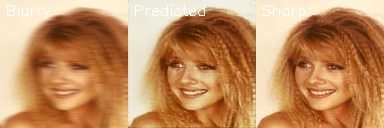

In [ ]:
# Step 7: Visualize Predictions from the Enhanced Model

# 7.1: Visualize a Single Prediction
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Choose a sample image file from the validation set
sample_filename = val_files[0]

# Construct paths
blurry_path = os.path.join(blurry_folder, sample_filename)
sharp_path = os.path.join(sharp_folder, sample_filename)

# Load and resize images
blurry_img = cv2.imread(blurry_path)
sharp_img = cv2.imread(sharp_path)

# Check if both images are loaded correctly
if blurry_img is None or sharp_img is None:
    print("One or both images could not be loaded.")
else:
    blurry_resized = cv2.resize(blurry_img, (128, 128))
    sharp_resized = cv2.resize(sharp_img, (128, 128))

    # Normalize and prepare for prediction
    input_img = np.expand_dims(blurry_resized.astype("float32") / 255.0, axis=0)
    prediction = unet_model.predict(input_img, verbose=0)
    predicted_img = (prediction[0] * 255).astype("uint8")

    # Add labels
    labeled_blur = cv2.putText(blurry_resized.copy(), "Blurry", (5, 15),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
    labeled_pred = cv2.putText(predicted_img.copy(), "Predicted", (5, 15),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
    labeled_sharp = cv2.putText(sharp_resized.copy(), "Sharp", (5, 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    # Concatenate images
    combined = np.hstack([labeled_blur, labeled_pred, labeled_sharp])
    cv2_imshow(combined)

In [ ]:
# Step 8: Evaluate Model Performance on Test Batches
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf

def evaluate_ssim_mae(model, data_gen, num_batches=10):
    total_ssim = 0.0
    total_mae = 0.0
    count = 0

    for batch_index in range(num_batches):
        x_batch, y_batch = data_gen[batch_index]
        preds = model.predict(x_batch, verbose=0)

        for pred_img, true_img in zip(preds, y_batch):
            pred_gray = tf.image.rgb_to_grayscale(pred_img).numpy().squeeze()
            true_gray = tf.image.rgb_to_grayscale(true_img).numpy().squeeze()

            # Calculate SSIM
            ssim_score = ssim(pred_gray, true_gray, data_range=1.0)
            total_ssim += ssim_score

            # Calculate MAE
            mae_score = np.mean(np.abs(pred_img - true_img))
            total_mae += mae_score

            count += 1

    avg_ssim = total_ssim / count if count else 0
    avg_mae = total_mae / count if count else 0
    return avg_ssim, avg_mae

# Run evaluation
avg_ssim, avg_mae = evaluate_ssim_mae(unet_model, val_gen, num_batches=10)
print(f"📈 Average SSIM: {avg_ssim:.4f}")
print(f"📉 Average MAE : {avg_mae:.4f}")

📈 Average SSIM: 0.9296
📉 Average MAE : 0.0222


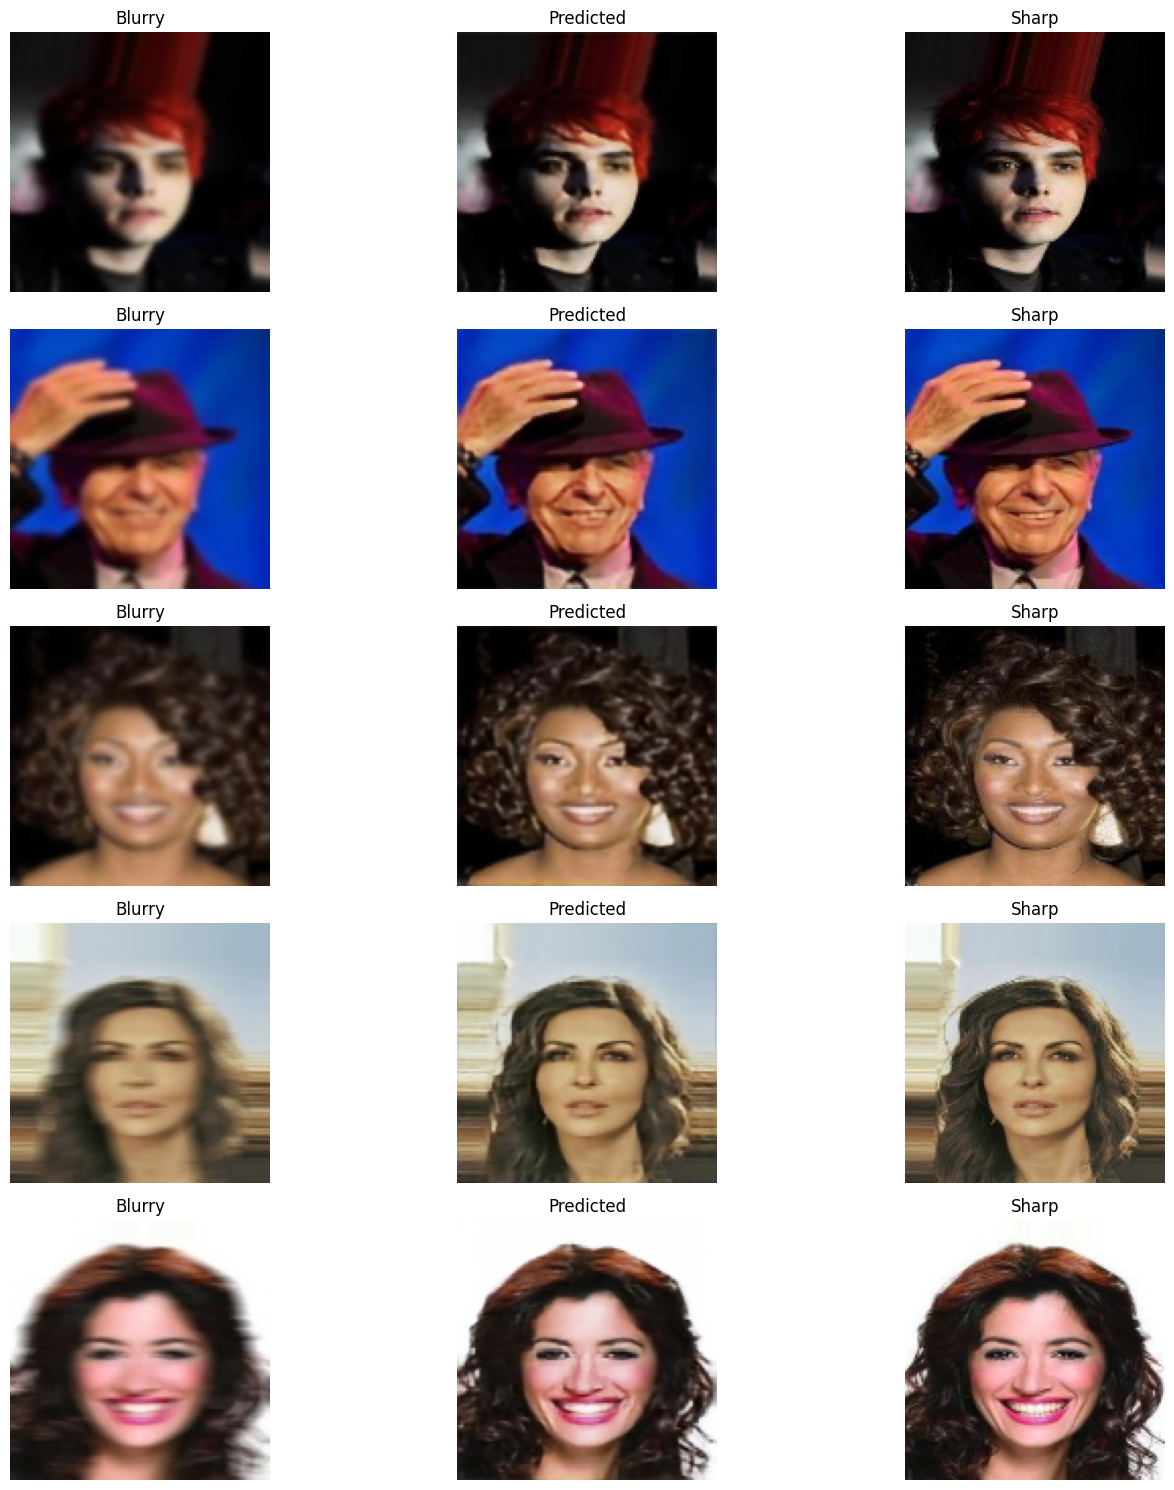

In [ ]:
import matplotlib.pyplot as plt

def visualize_multiple_predictions(model, data_gen, sample_indices=[0, 1, 2, 3, 4]):
    plt.figure(figsize=(15, len(sample_indices) * 3))

    for i, idx in enumerate(sample_indices):
        filename = val_files[idx]
        blur_path = os.path.join(blurry_folder, filename)
        sharp_path = os.path.join(sharp_folder, filename)

        # Read and resize
        blur = cv2.imread(blur_path)
        sharp = cv2.imread(sharp_path)

        if blur is None or sharp is None:
            print(f"Error loading image: {filename}")
            continue

        blur = cv2.resize(blur, (128, 128))
        sharp = cv2.resize(sharp, (128, 128))

        # Predict
        input_img = np.expand_dims(blur.astype("float32") / 255.0, axis=0)
        prediction = model.predict(input_img, verbose=0)[0]
        prediction = (prediction * 255).astype("uint8")

        # Plot
        plt.subplot(len(sample_indices), 3, i * 3 + 1)
        plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
        plt.title("Blurry")
        plt.axis('off')

        plt.subplot(len(sample_indices), 3, i * 3 + 2)
        plt.imshow(cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB))
        plt.title("Predicted")
        plt.axis('off')

        plt.subplot(len(sample_indices), 3, i * 3 + 3)
        plt.imshow(cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB))
        plt.title("Sharp")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display predictions for 5 validation images
visualize_multiple_predictions(unet_model, val_gen, sample_indices=[0, 10, 20, 30, 40])

In [ ]:
from google.colab import files
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Upload image
uploaded = files.upload()

Saving 153099.jpg to 153099.jpg


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError

model = load_model("/content/drive/MyDrive/TeacherModel2/teacher_unet.h5", compile=False)


#model = load_model("/content/drive/MyDrive/TeacherModel2/teacher_unet.h5",
                  # custom_objects={'mae': MeanAbsoluteError()})



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


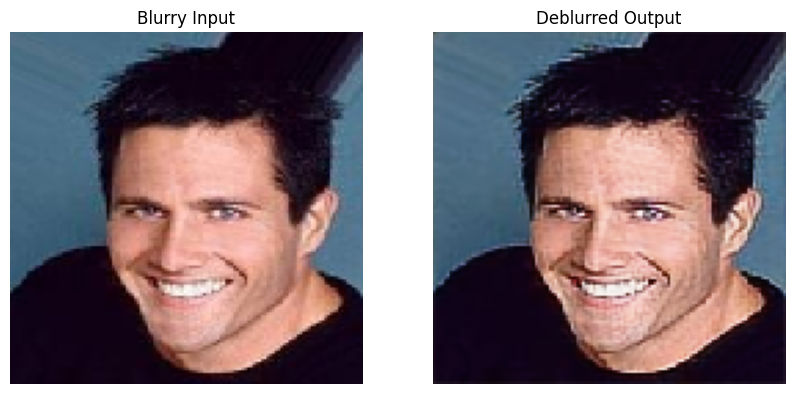

In [ ]:
def preprocess_image(img_path, img_size=(128, 128)):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0), img

def predict_and_display(model, img_path):
    input_array, original_image = preprocess_image(img_path)

    prediction = model.predict(input_array)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Blurry Input")
    plt.imshow(original_image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Deblurred Output")
    plt.imshow(np.clip(prediction[0], 0, 1))
    plt.axis("off")

    plt.show()

# Get uploaded filename
uploaded_filename = list(uploaded.keys())[0]
predict_and_display(model, uploaded_filename)


In [ ]:
from tensorflow.keras.models import load_model

model = load_model(
    "/content/drive/MyDrive/TeacherModel2/teacher_unet.h5",
    compile=False
)
model.summary()


Model: "Enhanced_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]  

 Total params: 469,155 (1.79 MB)

 Trainable params: 467,875 (1.78 MB)

 Non-trainable params: 1,280 (5.00 KB)